In [161]:
import io
import zipfile
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")

current_data_url = (
    "https://www.chmi.cz/files/portal/docs/"
    "meteo/ok/open_data_2023/RDATA/T/Praha/P1PKLE01_T_N.csv.zip"
)

historic_data_url = (
    "https://www.chmi.cz/files/portal/docs/meteo/ok/files/"
    "PKLM_pro_portal.xlsx"
)

# global, land + ocean
noaa_anomaly_data_url = (
    "https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/"
    "global/time-series/globe/land_ocean/all/12/1850-2024.csv"
)

# northern hemisphere, land only
noaa_anomaly_data_url = (
     "https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/"
    "global/time-series/nhem/land/p12/12/1850-2024.csv"
 )

%matplotlib inline

In [148]:
def load_historic_data() -> pd.DataFrame:
    data = (
        pd
        .read_excel(historic_data_url, sheet_name='data')
        .rename(
            columns={
                "rok": "year",
                "měsíc": "month",
                "den": "day",
            }
        )
        .drop(
            columns=["SRA", "Flag", "TMA", "TMI"]
        )
    )
    return data


def load_current_data() -> pd.DataFrame:
    raw_bytes = requests.get(current_data_url).content
    data = (
        zipfile
        .ZipFile(io.BytesIO(raw_bytes))
        .read("P1PKLE01_T_N.csv")
        .decode("windows-1250")
    )
    preprocessed_data = "\n".join(data.split("\n")[22:])
    return (
        pd
        .read_csv(
            io.StringIO(preprocessed_data),
            sep=";"
        )
        .rename(
            columns={
                "Rok": "year",
                "Měsíc": "month",
                "Den": "day",
                "Hodnota": "T-AVG",
            }
        )
        .drop(columns="Příznak")
    )


def load_noaa_anomaly_data() -> pd.DataFrame:
    data = (
        pd
        .read_csv(noaa_anomaly_data_url, skiprows=4)
        .rename(columns=lambda x: x.lower())
        
    )
    data["date"] = data["date"].map(lambda x: datetime.strptime(str(x), "%Y%m"))
    return data

In [96]:
def prepare_data(
    historic_data: pd.DataFrame,
    current_data: pd.DataFrame
) -> pd.DataFrame:
    
    data = pd.merge(
        left=historic_data,
        right=current_data,
        on=["year", "month", "day"],
        how="outer",
        suffixes=["_hist", "_curr"]
        
    )
    test_row = data.query("year == 1961").iloc[0, :]
    assert test_row["T-AVG_hist"] == test_row["T-AVG_curr"]
    
    data["T-AVG"] = data["T-AVG_hist"].combine_first(data["T-AVG_curr"])
    data["date"] = data.apply(
        lambda r: datetime(int(r["year"]), int(r["month"]), int(r["day"])),
        axis=1,
    )
    return data

In [97]:
def add_baseline(
    data: pd.DataFrame,
    baseline_range: tuple[int, int] = (1920, 1950)
) -> pd.DataFrame:
    baseline_mask = (
        (data["year"] >= baseline_range[0]).values &
        (data["year"] < baseline_range[1]).values
    )

    baseline = (
        data[baseline_mask]
        .groupby(["month", "day"])
        .agg({"T-AVG": "mean"})
        .reset_index()
        .rename(columns={"T-AVG": "T-AVG-BASE"})
    )
    return data.merge(
        right=baseline,
        how="left",
        left_on=["month", "day"],
        right_on=["month", "day"]
    )


def compute_anomalies(data: pd.DataFrame) -> pd.DataFrame:
    
    window_size_days = 11 * 365
    data["T-AVG-ANOMALY"] = data["T-AVG"] - data["T-AVG-BASE"]
    data["T-AVG-ANOMALY-11Y"] = (
        data["T-AVG-ANOMALY"]
        .rolling(
            window=window_size_days
        )
        .mean()
    )
    data["T-AVG-ANOMALY-11Y-STD"] = (
        data["T-AVG-ANOMALY"]
        .rolling(
            window=window_size_days
        )
        .std()
    )
    return data

In [125]:
def compute_model(
    data: pd.DataFrame,
    year_range: tuple[int, int]
) -> tuple[np.array, float, float]:
    model = LinearRegression()
    mask = (
        (data["year"] >= year_range[0]).values &
        (data["year"] <= year_range[1]).values &
        ~data["T-AVG-ANOMALY-11Y"].isna()
    )
    x = data.loc[mask, ["year"]].values
    y = data.loc[mask, "T-AVG-ANOMALY-11Y"]
    model.fit(x, y)
    
    return model.coef_, model.intercept_, r2_score(y, model.predict(x))

In [166]:
def generate_plot(data, noaa_anomaly_data):
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    x = data["date"].tolist()
    y = data["T-AVG-ANOMALY-11Y"].tolist()
    
    x_noaa = noaa_anomaly_data["date"].tolist()
    y_noaa = noaa_anomaly_data["anomaly"].tolist()

    ax.plot(x_noaa, y_noaa, "r", alpha=0.4, label="NOAA global anomaly")
    ax.plot(x, y, "b", alpha=0.8, label="11 year moving average baseline difference")
    ax.plot([x[0], x[-1]], [0, 0], 'g--', alpha=0.5, label="1920-1950 baseline")
    ax.set_title("Temperature 1775-2023 at Klementinum, Prague, Czech Republic")
    ax.set_xlabel("Year")
    ax.set_ylabel("Temperature Anomaly [°C]")
    

    # for i, x_model in enumerate([[1780, 1950], [1975, 2023]]):
    #     a, b, r2 = compute_model(data, x_model)
    #     label = f"Trend {x_model[0]}-{x_model[1]}, a={a[0]:.3f}, R2={r2:.3f}"
    
    #     x = [datetime(x, 1, 1) for x in x_model]
    #     y = [a * x + b for x in x_model]
    #     ax.plot(x, y, "r" if i else 'y', label=label)

    plt.legend()
    plt.show()

In [149]:
historic_data = load_historic_data()
current_data = load_current_data()

In [162]:
noaa_anomaly_data = load_noaa_anomaly_data()

In [127]:
data = prepare_data(historic_data, current_data)
data = add_baseline(data)
data = compute_anomalies(data)

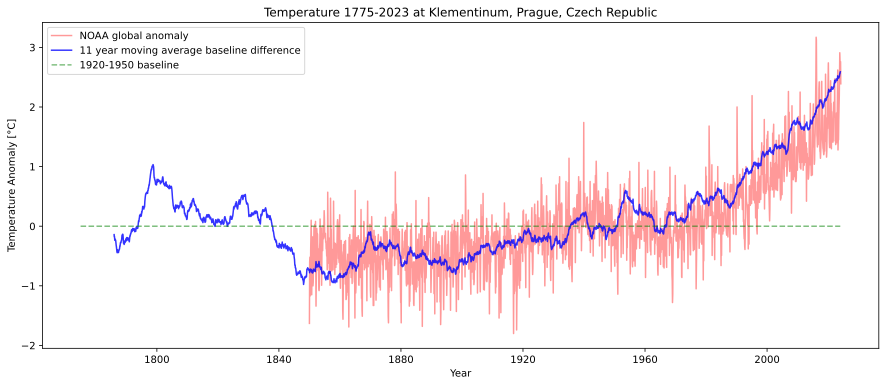

In [167]:
generate_plot(data, noaa_anomaly_data)